<a href="https://colab.research.google.com/github/Ambrish001/Coastline_Monitoring/blob/main/UNet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imagecodecs
!pip install segmentation-models==1.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.0 MB 95.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%tensorflow_version 1.x
import numpy as np
import pandas as pd
import glob
import os
import cv2
from matplotlib import pyplot as plt
import tifffile as tiff
#import imagecodecs as ic
#import segmentation_models as sm
#from patchify import patchify

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
path_img = sorted(glob.glob("/content/drive/MyDrive/UCD_Research/Sat_Data/*.TIF"))
path_msk = sorted(glob.glob("/content/drive/MyDrive/UCD_Research/Sat_Data/*_mask.tif"))
large_image_stack = []
large_msk_stack = []
for file in path_msk:
  x = cv2.imread(file)
  y = cv2.resize(x,(256,256),interpolation = cv2.INTER_CUBIC)
  large_msk_stack.append(y)  
for file in path_img:
  x = cv2.imread(file)
  y = cv2.resize(x,(256,256),interpolation = cv2.INTER_CUBIC)
  large_image_stack.append(y)

In [ ]:
print(large_image_stack[0].shape,len(large_image_stack))
print(large_msk_stack[0].shape,len(large_msk_stack))

(256, 256, 3) 91
(256, 256, 3) 91


In [ ]:
img_arr = np.array([i for i in large_image_stack])
msk_arr = np.array([i for i in large_msk_stack])

In [ ]:
BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)
# preprocess input
img_arr_pro = preprocess_input1(img_arr)
print(img_arr_pro.shape)

(91, 1920, 1080, 3)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img_arr, msk_arr, test_size = 0.2, random_state = 42)
print(X_train.shape)
print(X_test.shape)


(72, 256, 256, 3)
(19, 256, 256, 3)


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(3, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

Using TensorFlow backend.


In [ ]:
IMG_HEIGHT = img_arr.shape[1]
IMG_WIDTH  = img_arr.shape[2]
IMG_CHANNELS = img_arr.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(256, 256, 3)


In [ ]:
import tensorflow as tf
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 64) 0           batch_normalization_1[0][0]      
____

In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=75, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 72 samples, validate on 19 samples
Epoch 1/75
72/72 [==============================] - 28s 393ms/step - loss: 387.1445 - accuracy: 0.7835 - val_loss: 440.6147 - val_accuracy: 0.3564
Epoch 2/75
72/72 [==============================] - 4s 59ms/step - loss: 369.7234 - accuracy: 0.9182 - val_loss: 386.8701 - val_accuracy: 0.3564
Epoch 3/75
72/72 [==============================] - 4s 60ms/step - loss: 368.7975 - accuracy: 0.9449 - val_loss: 386.1619 - val_accuracy: 0.3564
Epoch 4/75
72/72 [==============================] - 4s 60ms/step - loss: 368.4172 - accuracy: 0.9408 - val_loss: 386.1619 - val_accuracy: 0.3564
Epoch 5/75
72/72 [==============================] - 4s 59ms/step - loss: 368.2237 - accuracy: 0.9458 - val_loss: 386.1619 - val_accuracy: 0.3564
Epoch 6/75
72/72 [==============================] - 4s 59ms/step - loss: 368.0417 - accuracy: 0.9525 - val_loss: 386.1619 - val_accura

In [ ]:
model.save('/content/drive/MyDrive/UCD_Research/model1_75epochs.hdf5')

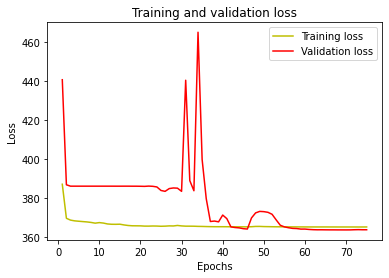

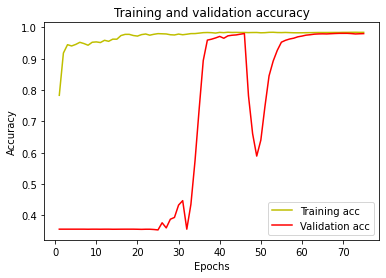

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
print(model.summary())

In [ ]:
history = model.fit(img_arr_pro, validation_data=, steps_per_epoch=50, validation_steps=50, epochs=50)
